In [3]:
library('boot')
library('ggplot2')
#install.packages('corrplot')
options(repr.plot.width=6, repr.plot.height=4) 

## Preparations

### 1. Loading and Cleaning the Data

#### Loading the data and initial inspection

In [8]:
data <- read.csv(file="skoda.csv")

head(data)
summary(data)

model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
Octavia,2017,10550,Manual,25250,Petrol,150,54.3,1.4
Citigo,2018,8200,Manual,1264,Petrol,145,67.3,1.0
Octavia,2019,15650,Automatic,6825,Diesel,145,67.3,2.0
Yeti Outdoor,2015,14000,Automatic,28431,Diesel,165,51.4,2.0
Superb,2019,18350,Manual,10912,Petrol,150,40.9,1.5
Yeti Outdoor,2017,13250,Automatic,47005,Diesel,145,51.4,2.0


           model           year          price          transmission 
  Fabia       :1571   Min.   :2004   Min.   :  995   Automatic:1104  
  Octavia     :1477   1st Qu.:2017   1st Qu.: 9495   Manual   :3754  
  Superb      : 791   Median :2018   Median :12998   Other    :   1  
  Kodiaq      : 472   Mean   :2018   Mean   :14275   Semi-Auto:1408  
  Citigo      : 470   3rd Qu.:2019   3rd Qu.:17990                   
  Yeti Outdoor: 458   Max.   :2020   Max.   :91874                   
 (Other)      :1028                                                  
    mileage         fuelType         tax             mpg        
 Min.   :     5   Diesel:2069   Min.   :  0.0   Min.   : 30.10  
 1st Qu.:  5812   Hybrid:  18   1st Qu.:125.0   1st Qu.: 50.40  
 Median : 14653   Other :   9   Median :145.0   Median : 57.70  
 Mean   : 20118   Petrol:4171   Mean   :117.4   Mean   : 56.59  
 3rd Qu.: 28000                 3rd Qu.:145.0   3rd Qu.: 62.80  
 Max.   :300000                 Max.   :325.0   Ma

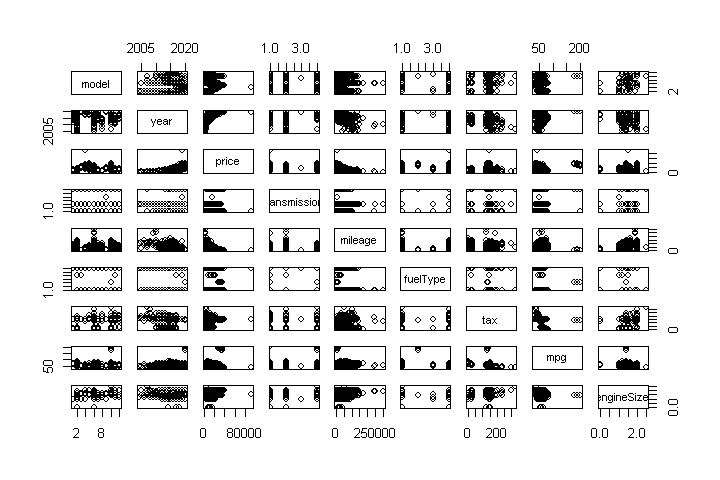

In [10]:
pairs(data)

#### Problem: enginesize = 0
What does it mean? Is it an electric car?

In [13]:
data$engineSize <- as.factor(data$engineSize)
table(data$engineSize)
index <- which(data$engineSize == 0)
data[index,]


   0    1  1.2  1.4  1.5  1.6  1.8  1.9    2  2.5 
   5 1939  958  420  626  672    4    7 1635    1 

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
5189,Octavia,2017,16000,Automatic,16166,Diesel,145,61.4,0
5277,Octavia,2017,10700,Manual,38552,Petrol,150,55.4,0
5335,Fabia,2014,7500,Automatic,26008,Petrol,125,53.3,0
5374,Fabia,2018,11500,Manual,10720,Petrol,150,64.2,0
5441,Octavia,2017,15400,Automatic,19576,Diesel,145,61.4,0


Conclusion: we remove these few observations

In [16]:
data2 <- data[-index,]
row.names(data2) <- NULL  # reset indices

summary(data2)

           model           year          price          transmission 
  Fabia       :1569   Min.   :2004   Min.   :  995   Automatic:1101  
  Octavia     :1474   1st Qu.:2017   1st Qu.: 9495   Manual   :3752  
  Superb      : 791   Median :2018   Median :12998   Other    :   1  
  Kodiaq      : 472   Mean   :2018   Mean   :14277   Semi-Auto:1408  
  Citigo      : 470   3rd Qu.:2019   3rd Qu.:17990                   
  Yeti Outdoor: 458   Max.   :2020   Max.   :91874                   
 (Other)      :1028                                                  
    mileage         fuelType         tax             mpg           engineSize  
 Min.   :     5   Diesel:2067   Min.   :  0.0   Min.   : 30.10   1      :1939  
 1st Qu.:  5808   Hybrid:  18   1st Qu.:125.0   1st Qu.: 50.40   2      :1635  
 Median : 14652   Other :   9   Median :145.0   Median : 57.70   1.2    : 958  
 Mean   : 20117   Petrol:4168   Mean   :117.4   Mean   : 56.59   1.6    : 672  
 3rd Qu.: 28000                 3rd Qu.:

#### Another problem:
one item costs $91874$, while the rest of the summary suggests this might be an outlier (inflated or incorrect value).

In [19]:
# a few observations sorted by price
head(data2[order(data2$price, decreasing = TRUE),])

# a few observations of the Karoq model sorted by price
index <- which(data2$model == " Karoq")
temp <- data2[index,]
temp <- temp[order(temp$price, decreasing = TRUE),]
temp[1:10,]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
4994,Karoq,2019,91874,Automatic,3764,Petrol,145,40.9,1.5
4353,Superb,2019,39001,Semi-Auto,5000,Petrol,145,32.5,2
3331,Kodiaq,2020,38990,Automatic,493,Diesel,145,34.9,2
4561,Kodiaq,2020,37999,Automatic,5600,Diesel,150,34.9,2
6121,Kodiaq,2020,36999,Semi-Auto,1000,Diesel,145,39.2,2
2489,Kodiaq,2019,36995,Automatic,2261,Diesel,145,35.3,2


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
4994,Karoq,2019,91874,Automatic,3764,Petrol,145,40.9,1.5
6215,Karoq,2020,31990,Semi-Auto,2000,Petrol,145,33.2,2
1118,Karoq,2019,30843,Manual,4521,Diesel,145,42.8,2
2907,Karoq,2020,30490,Automatic,6560,Diesel,145,41.5,2
309,Karoq,2019,30000,Manual,766,Diesel,145,42.8,2
2949,Karoq,2019,29995,Automatic,4786,Diesel,145,41.5,2
3619,Karoq,2019,29995,Manual,4000,Diesel,145,42.8,2
3878,Karoq,2020,29995,Manual,2000,Diesel,145,42.8,2
1205,Karoq,2019,29838,Manual,3489,Diesel,145,42.8,2
1521,Karoq,2019,29700,Automatic,9393,Diesel,145,41.5,2


Conclusion: we remove one observation

In [22]:
index <- which(data2$price==91874)

data3 <- data2[-index,]
row.names(data3) <- NULL

In [24]:
summary(data3)

           model           year          price          transmission 
  Fabia       :1569   Min.   :2004   Min.   :  995   Automatic:1100  
  Octavia     :1474   1st Qu.:2017   1st Qu.: 9495   Manual   :3752  
  Superb      : 791   Median :2018   Median :12998   Other    :   1  
  Kodiaq      : 472   Mean   :2018   Mean   :14265   Semi-Auto:1408  
  Citigo      : 470   3rd Qu.:2019   3rd Qu.:17990                   
  Yeti Outdoor: 458   Max.   :2020   Max.   :39001                   
 (Other)      :1027                                                  
    mileage         fuelType         tax             mpg           engineSize  
 Min.   :     5   Diesel:2067   Min.   :  0.0   Min.   : 30.10   1      :1939  
 1st Qu.:  5810   Hybrid:  18   1st Qu.:125.0   1st Qu.: 50.40   2      :1635  
 Median : 14652   Other :   9   Median :145.0   Median : 57.70   1.2    : 958  
 Mean   : 20119   Petrol:4167   Mean   :117.4   Mean   : 56.59   1.6    : 672  
 3rd Qu.: 28000                 3rd Qu.:

#### We create a new variable "age" as the age of the car from the year 2020.

In [27]:
table(data3$year)
data3$age <- 2020 - data3$year
head(data3)


2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 
   1    2    3    4    6    6   10   14   17   93  182  285  840 1536  873 2113 
2020 
 276 

model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
Octavia,2017,10550,Manual,25250,Petrol,150,54.3,1.4,3
Citigo,2018,8200,Manual,1264,Petrol,145,67.3,1,2
Octavia,2019,15650,Automatic,6825,Diesel,145,67.3,2,1
Yeti Outdoor,2015,14000,Automatic,28431,Diesel,165,51.4,2,5
Superb,2019,18350,Manual,10912,Petrol,150,40.9,1.5,1
Yeti Outdoor,2017,13250,Automatic,47005,Diesel,145,51.4,2,3


#### Categorical variables

In [30]:
#qplot(data3$model, ylab = 'Count', xlab = 'Model')
table(data3$model)


       Citigo         Fabia         Kamiq         Karoq        Kodiaq 
          470          1569           141           389           472 
      Octavia         Rapid      Roomster         Scala        Superb 
         1474           152            17           192           791 
         Yeti  Yeti Outdoor 
          136           458 

In [32]:
table(data3$transmission)
#barplot(table(data3$transmission))


Automatic    Manual     Other Semi-Auto 
     1100      3752         1      1408 

In [34]:
table(data3$fuelType)
#barplot(table(data3$fuelType))


Diesel Hybrid  Other Petrol 
  2067     18      9   4167 

In [36]:
table(data3$engineSize)
#barplot(table(data3$engineSize))


   0    1  1.2  1.4  1.5  1.6  1.8  1.9    2  2.5 
   0 1939  958  420  625  672    4    7 1635    1 

Question: for which observation do we get 2.5?

In [39]:
data3[which(data3$engineSize==2.5),]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
5774,Superb,2007,3495,Semi-Auto,47000,Diesel,325,35.8,2.5,13


#### Cleaned data

In [42]:
data_clean <- data3[,-2]
head(data_clean)
summary(data_clean)
names(data_clean)

model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
Octavia,10550,Manual,25250,Petrol,150,54.3,1.4,3
Citigo,8200,Manual,1264,Petrol,145,67.3,1,2
Octavia,15650,Automatic,6825,Diesel,145,67.3,2,1
Yeti Outdoor,14000,Automatic,28431,Diesel,165,51.4,2,5
Superb,18350,Manual,10912,Petrol,150,40.9,1.5,1
Yeti Outdoor,13250,Automatic,47005,Diesel,145,51.4,2,3


           model          price          transmission     mileage      
  Fabia       :1569   Min.   :  995   Automatic:1100   Min.   :     5  
  Octavia     :1474   1st Qu.: 9495   Manual   :3752   1st Qu.:  5810  
  Superb      : 791   Median :12998   Other    :   1   Median : 14652  
  Kodiaq      : 472   Mean   :14265   Semi-Auto:1408   Mean   : 20119  
  Citigo      : 470   3rd Qu.:17990                    3rd Qu.: 28000  
  Yeti Outdoor: 458   Max.   :39001                    Max.   :300000  
 (Other)      :1027                                                    
   fuelType         tax             mpg           engineSize        age        
 Diesel:2067   Min.   :  0.0   Min.   : 30.10   1      :1939   Min.   : 0.000  
 Hybrid:  18   1st Qu.:125.0   1st Qu.: 50.40   2      :1635   1st Qu.: 1.000  
 Other :   9   Median :145.0   Median : 57.70   1.2    : 958   Median : 2.000  
 Petrol:4167   Mean   :117.4   Mean   : 56.59   1.6    : 672   Mean   : 2.497  
               3rd Qu.:1

[1] "model"        "price"        "transmission" "mileage"      "fuelType"    
[6] "tax"          "mpg"          "engineSize"   "age"

### 2. Correlation plots, dependency plots

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


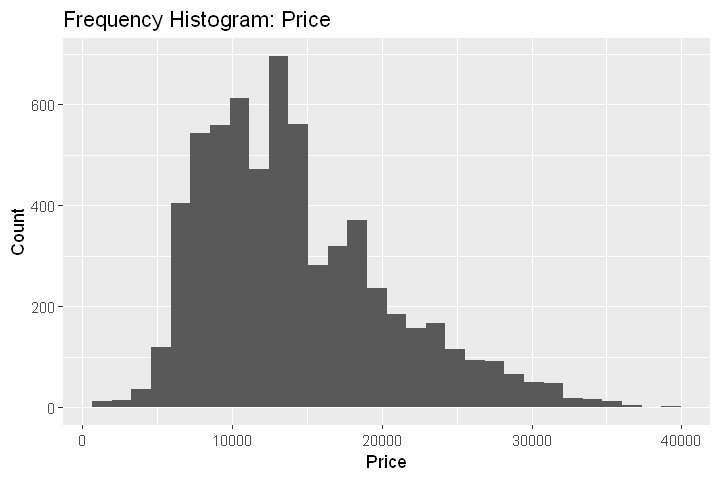

In [45]:
qplot(data_clean$price, xlab = 'Price', ylab = 'Count', main='Frequency Histogram: Price')

In [47]:
library('corrplot')
cor_mat <- cor(data_clean[,-c(1,3,5,8)])

corrplot(cor_mat, method = 'color')
#corrplot(cor_mat, method = 'number')

ERROR: Error in library("corrplot"): there is no package called 'corrplot'


#### Dependency and lack-of-dependency plots – quantitative variables

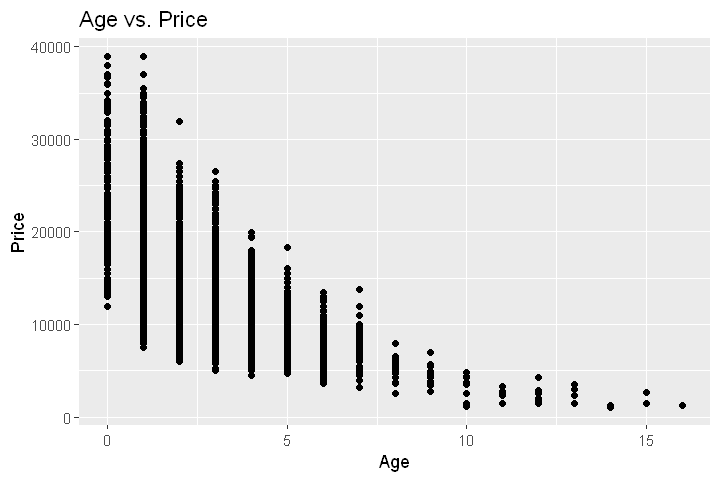

In [50]:
ggplot(data = data_clean, aes(x = age, y = price)) +
  geom_point() +
  xlab('Age') +
  ylab('Price') +
  ggtitle('Age vs. Price')

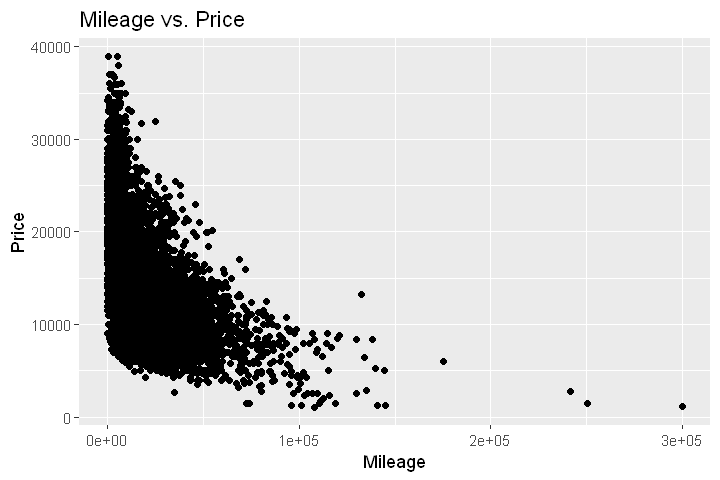

In [52]:
ggplot(data = data_clean, aes(x = mileage, y = price)) +
  geom_point() +
  xlab('Mileage') +
  ylab('Price') +
  ggtitle('Mileage vs. Price')

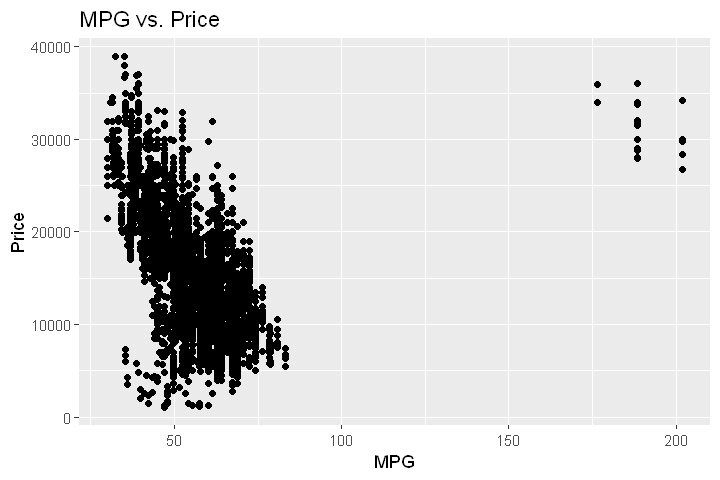

In [53]:
ggplot(data = data_clean, aes(x = mpg, y = price)) +
  geom_point() +
  xlab('MPG') +
  ylab('Price') +
  ggtitle('MPG vs. Price')

Question: those outlier values on the top right side?

In [56]:
data3[which(data3$mpg > 83), ][order(data3[which(data3$mpg > 83), ]$mpg, decreasing = TRUE), ]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
427,Superb,2020,34232,Semi-Auto,15,Hybrid,140,201.8,1.4,0
3970,Superb,2020,28332,Semi-Auto,5000,Hybrid,135,201.8,1.4,0
4214,Superb,2020,29995,Semi-Auto,15,Hybrid,140,201.8,1.4,0
5060,Superb,2020,29799,Automatic,897,Hybrid,135,201.8,1.4,0
6106,Superb,2020,26795,Automatic,3600,Hybrid,135,201.8,1.4,0
281,Superb,2020,28084,Semi-Auto,9500,Hybrid,135,188.3,1.4,0
411,Superb,2020,28785,Semi-Auto,1548,Hybrid,135,188.3,1.4,0
1661,Superb,2020,29991,Semi-Auto,3565,Hybrid,135,188.3,1.4,0
1887,Superb,2020,31795,Semi-Auto,2000,Hybrid,135,188.3,1.4,0
1917,Superb,2020,27995,Semi-Auto,4500,Hybrid,140,188.3,1.4,0


Comment: all outliers are the Superb model, they are hybrids.

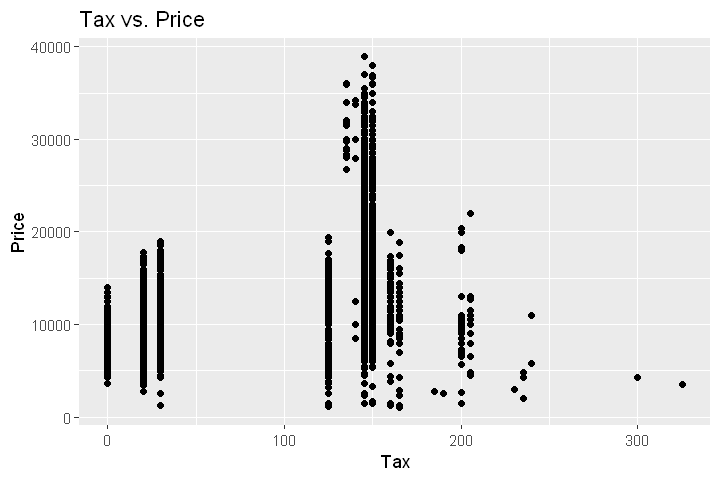

In [59]:
ggplot(data = data_clean, aes(x = tax, y = price)) +
  geom_point() +
  xlab('Tax') +
  ylab('Price') +
  ggtitle('Tax vs. Price')

#### Dependency and lack-of-dependency plots – categorical variables

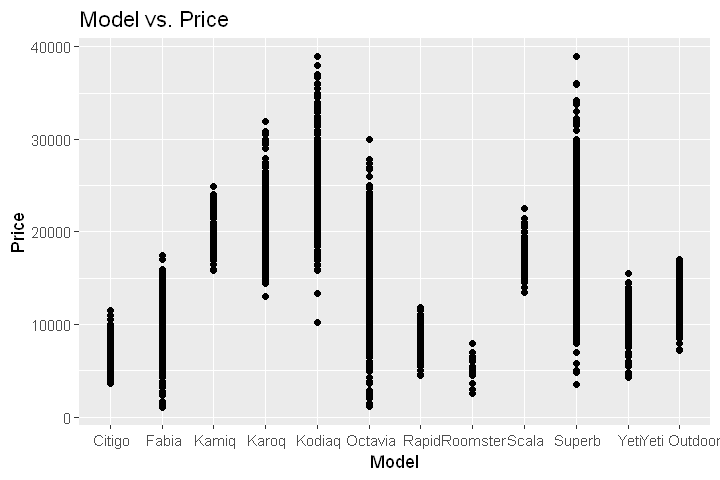

In [61]:
ggplot(data = data_clean, aes(x = model, y = price)) +
  geom_point() +
  xlab('Model') +
  ylab('Price') +
  ggtitle('Model vs. Price')

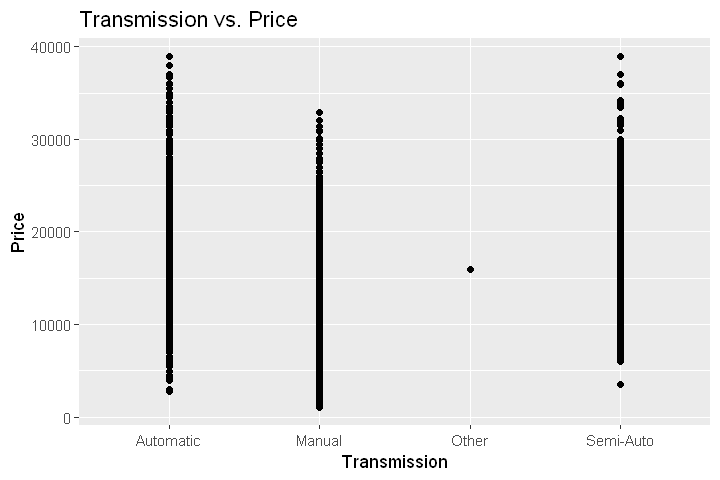

In [62]:
ggplot(data = data_clean, aes(x = transmission, y = price)) +
  geom_point() +
  xlab('Transmission') +
  ylab('Price') +
  ggtitle('Transmission vs. Price')

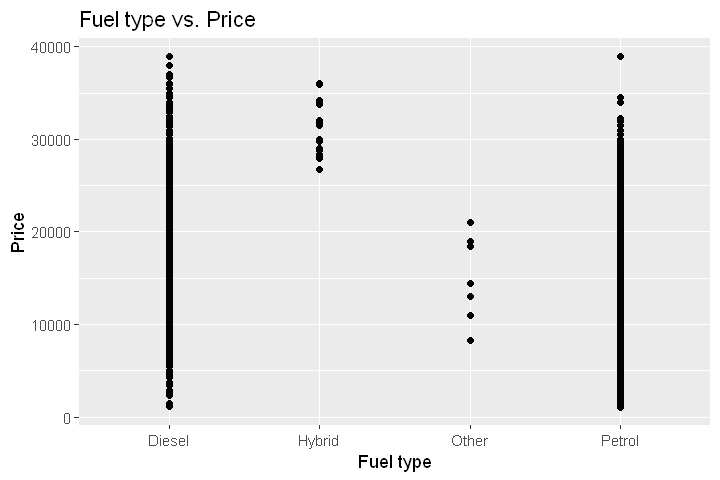

In [63]:
ggplot(data = data_clean, aes(x = fuelType, y = price)) +
  geom_point() +
  xlab('Fuel type') +
  ylab('Price') +
  ggtitle('Fuel type vs. Price')

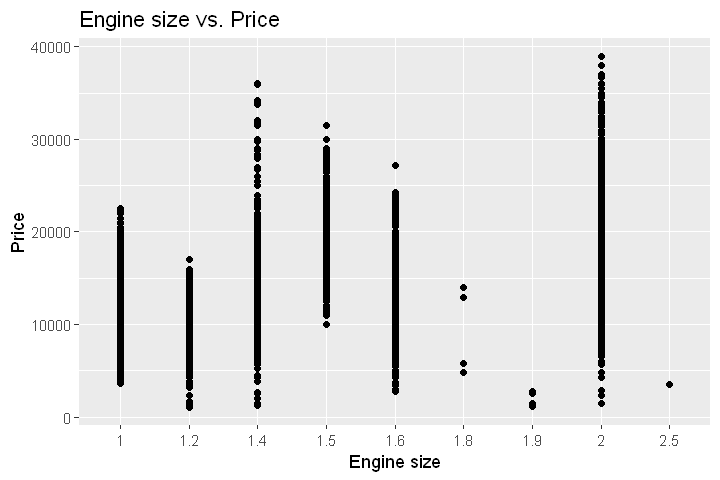

In [64]:
ggplot(data = data_clean, aes(x = engineSize, y = price)) +
  geom_point() +
  xlab('Engine size') +
  ylab('Price') +
  ggtitle('Engine size vs. Price')

### 3. Preparing data for model building

#### Dummies – converting categorical variables to binary

In [68]:
# cleaning text data from white spaces (there was a problem with model)
library(stringr)
data_clean$model <- str_trim(data_clean$model)
data_clean$transmission <- str_trim(data_clean$transmission)
data_clean$fuelType <- str_trim(data_clean$fuelType)

In [70]:
names(data_clean)

# number of observations, number of columns
dim(data_clean)

[1] "model"        "price"        "transmission" "mileage"      "fuelType"    
[6] "tax"          "mpg"          "engineSize"   "age"

[1] 6261    9

Categorical variables are:
- model
- transmission
- fuelType
- engineSize

In [73]:
#unique(data_clean$model)
data_clean$model_octavia <- ifelse(data_clean$model == "Octavia", 1, 0)
data_clean$model_citigo <- ifelse(data_clean$model == "Citigo", 1, 0)
data_clean$model_yeti_out <- ifelse(data_clean$model == "Yeti Outdoor", 1, 0)
data_clean$model_superb <- ifelse(data_clean$model == "Superb", 1, 0)
data_clean$model_kodiaq <- ifelse(data_clean$model == "Kodiaq", 1, 0)
data_clean$model_rapid <- ifelse(data_clean$model == "Rapid", 1, 0)
data_clean$model_karoq <- ifelse(data_clean$model == "Karoq", 1, 0)
data_clean$model_fabia <- ifelse(data_clean$model == "Fabia", 1, 0)
data_clean$model_yeti <- ifelse(data_clean$model == "Yeti", 1, 0)
data_clean$model_scala <- ifelse(data_clean$model == "Scala", 1, 0)
data_clean$model_roomster <- ifelse(data_clean$model == "Roomster", 1, 0)
data_clean$model_kamiq <- ifelse(data_clean$model == "Kamiq", 1, 0)

test <- data_clean[,c(10:21)]
sum(test) #equals the number of observations in data_clean, so it's correct

#unique(data_clean$transmission)
data_clean$transmission_manual <- ifelse(data_clean$transmission == "Manual", 1, 0)
data_clean$transmission_automatic <- ifelse(data_clean$transmission == "Automatic", 1, 0)
data_clean$transmission_semiauto <- ifelse(data_clean$transmission == "Semi-Auto", 1, 0)
data_clean$transmission_other <- ifelse(data_clean$transmission == "Other", 1, 0)

test <- data_clean[,c(22:25)]
sum(test) #equals the number of observations in data_clean, so it's correct

#unique(data_clean$fuelType)
data_clean$fuelType_petrol <- ifelse(data_clean$fuelType == "Petrol", 1, 0)
data_clean$fuelType_diesel <- ifelse(data_clean$fuelType == "Diesel", 1, 0)
data_clean$fuelType_hybrid <- ifelse(data_clean$fuelType == "Hybrid", 1, 0)
data_clean$fuelType_other <- ifelse(data_clean$fuelType == "Other", 1, 0)

test <- data_clean[,c(26:29)]
sum(test) #equals the number of observations in data_clean, so it's correct

#unique(data_clean$engineSize)
data_clean$engineSize_2.0 <- ifelse(data_clean$engineSize == 2.0, 1, 0)
data_clean$engineSize_1.2 <- ifelse(data_clean$engineSize == 1.2, 1, 0)
data_clean$engineSize_1.6 <- ifelse(data_clean$engineSize == 1.6, 1, 0)
data_clean$engineSize_1.0 <- ifelse(data_clean$engineSize == 1.0, 1, 0)
data_clean$engineSize_1.5 <- ifelse(data_clean$engineSize == 1.5, 1, 0)
data_clean$engineSize_1.4 <- ifelse(data_clean$engineSize == 1.4, 1, 0)
data_clean$engineSize_1.9 <- ifelse(data_clean$engineSize == 1.9, 1, 0)
data_clean$engineSize_1.8 <- ifelse(data_clean$engineSize == 1.8, 1, 0)
data_clean$engineSize_2.5 <- ifelse(data_clean$engineSize == 2.5, 1, 0)
test <- data_clean[,c(30:38)]
sum(test) #equals the number of observations in data_clean, so it's correct

#removing unnecessary columns
#names(data_clean)
data_clean2 <- data_clean[,-c(1,3,5,8)]
names(data_clean2)


[1] 6261

[1] 6261

[1] 6261

[1] 6261

[1] "price"                  "mileage"                "tax"                   
 [4] "mpg"                    "age"                    "model_octavia"         
 [7] "model_citigo"           "model_yeti_out"         "model_superb"          
[10] "model_kodiaq"           "model_rapid"            "model_karoq"           
[13] "model_fabia"            "model_yeti"             "model_scala"           
[16] "model_roomster"         "model_kamiq"            "transmission_manual"   
[19] "transmission_automatic" "transmission_semiauto"  "transmission_other"    
[22] "fuelType_petrol"        "fuelType_diesel"        "fuelType_hybrid"       
[25] "fuelType_other"         "engineSize_2.0"         "engineSize_1.2"        
[28] "engineSize_1.6"         "engineSize_1.0"         "engineSize_1.5"        
[31] "engineSize_1.4"         "engineSize_1.9"         "engineSize_1.8"        
[34] "engineSize_2.5"

#### Training and test set


In [76]:
set.seed(123) #Setting seed for reproducibility
permuted_indices <- sample(nrow(data_clean2)) #Random permutation of indices
data_clean2 <- data_clean2[permuted_indices,]
length(data_clean2$price)*0.75

[1] 4695.75

In [78]:
# Creating training and test sets:
train_indices <- 1:4696
test_indices <- 4697:6261

train <- data_clean2[train_indices,]
test <- data_clean2[-train_indices,]

In [80]:
head(train)

,price,mileage,tax,mpg,age,model_octavia,model_citigo,model_yeti_out,model_superb,model_kodiaq,...,fuelType_other,engineSize_2.0,engineSize_1.2,engineSize_1.6,engineSize_1.0,engineSize_1.5,engineSize_1.4,engineSize_1.9,engineSize_1.8,engineSize_2.5
2463,16590,28691,125,58.9,3,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2511,10999,33700,125,51.4,3,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2227,7695,59465,0,67.3,4,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
526,9298,11572,145,57.7,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4291,18990,483,150,44.1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2986,15750,32539,125,56.5,4,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## MODELS

### 4. Regression models and cross-validation

In [84]:
model1 <- glm(price ~ 1, data = train)
model2 <- glm(price ~ age, data = train)
model3 <- glm(price ~ age + mileage, data = train)
model4 <- glm(price ~., data = train)
model5 <- step(model4, direction = "backward",)
model6 <- step(model1, direction = "forward", scope = formula(model4))

model <- list(model1, model2, model3, model4, model5, model6)

Start:  AIC=83523.59
price ~ mileage + tax + mpg + age + model_octavia + model_citigo + 
    model_yeti_out + model_superb + model_kodiaq + model_rapid + 
    model_karoq + model_fabia + model_yeti + model_scala + model_roomster + 
    model_kamiq + transmission_manual + transmission_automatic + 
    transmission_semiauto + transmission_other + fuelType_petrol + 
    fuelType_diesel + fuelType_hybrid + fuelType_other + engineSize_2.0 + 
    engineSize_1.2 + engineSize_1.6 + engineSize_1.0 + engineSize_1.5 + 
    engineSize_1.4 + engineSize_1.9 + engineSize_1.8 + engineSize_2.5


Step:  AIC=83523.59
price ~ mileage + tax + mpg + age + model_octavia + model_citigo + 
    model_yeti_out + model_superb + model_kodiaq + model_rapid + 
    model_karoq + model_fabia + model_yeti + model_scala + model_roomster + 
    model_kamiq + transmission_manual + transmission_automatic + 
    transmission_semiauto + transmission_other + fuelType_petrol + 
    fuelType_diesel + fuelType_hybrid + fuelType_

In [85]:
options(warn=-1) # a few warnings appear below

errors <- c()
for(i in 1:length(model)){
  errors[i] <- cv.glm(train, model[[i]], K=10)$delta[1]
}

errors

options(warn=0)


[1] 39692850 24801033 24634506  3135184  3115745  3114297

In [87]:
length(names(model4$coefficients)) #34
length(names(model5$coefficients)) #27
length(names(model6$coefficients)) #25

[1] 34

[1] 27

[1] 25

In [89]:
formula(model5)
formula(model6)

price ~ mileage + tax + mpg + age + model_octavia + model_citigo + 
    model_yeti_out + model_kodiaq + model_rapid + model_karoq + 
    model_fabia + model_yeti + model_scala + model_roomster + 
    transmission_automatic + transmission_semiauto + fuelType_diesel + 
    fuelType_hybrid + engineSize_2.0 + engineSize_1.2 + engineSize_1.6 + 
    engineSize_1.0 + engineSize_1.5 + engineSize_1.4 + engineSize_1.9 + 
    engineSize_1.8

price ~ age + engineSize_1.0 + model_kodiaq + engineSize_2.0 + 
    transmission_manual + model_karoq + model_superb + mileage + 
    model_kamiq + fuelType_hybrid + mpg + fuelType_diesel + model_octavia + 
    model_scala + model_yeti_out + engineSize_1.9 + engineSize_1.6 + 
    model_citigo + tax + model_yeti + engineSize_2.5 + engineSize_1.2 + 
    engineSize_1.8 + transmission_automatic

In [91]:
summary(model6)


Call:
glm(formula = price ~ age + engineSize_1.0 + model_kodiaq + engineSize_2.0 + 
    transmission_manual + model_karoq + model_superb + mileage + 
    model_kamiq + fuelType_hybrid + mpg + fuelType_diesel + model_octavia + 
    model_scala + model_yeti_out + engineSize_1.9 + engineSize_1.6 + 
    model_citigo + tax + model_yeti + engineSize_2.5 + engineSize_1.2 + 
    engineSize_1.8 + transmission_automatic, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-9054.3  -1047.4    -86.5    926.1  11788.9  

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             2.592e+04  3.500e+02  74.056  < 2e-16 ***
age                    -9.703e+02  2.523e+01 -38.457  < 2e-16 ***
engineSize_1.0         -7.715e+02  1.160e+02  -6.651 3.23e-11 ***
model_kodiaq            7.737e+03  1.669e+02  46.359  < 2e-16 ***
engineSize_2.0          2.429e+03  1.369e+02  17.745  < 2e-16 ***
transmission_manual    -1.395e+03  7.166e+01 

#### Prediction

In [94]:
prediction <- predict.glm(model6, test)

In [96]:
head(prediction)

491       440        89      5075       508      2197 
 8997.682 11488.944  9945.826  7379.090 13855.353 14132.003

In [98]:
head(test$price)

[1]  7599 11998 10700  6500 11910 12999

In [100]:
mse_lm <- mean((prediction-test$price)**2)
mse_lm
# 2778571

[1] 2778571

In [102]:
mae_lm <- mean(abs(prediction-test$price))
mae_lm
# 1250.026

[1] 1250.026

### 5. Boostrap


In [105]:
boot.fn <- function(data, index){
  coef(glm(price ~ age + engineSize_1.0 + model_kodiaq + engineSize_2.0 + 
             transmission_manual + model_karoq + model_superb + mileage + 
             model_kamiq + fuelType_hybrid + mpg + fuelType_diesel + model_octavia + 
             model_scala + model_yeti_out + engineSize_1.9 + engineSize_1.6 + 
             model_citigo + tax + model_yeti + engineSize_2.5 + engineSize_1.2 + 
             engineSize_1.8 + transmission_automatic, data = data, subset = index))
}

len_train <- length(train$price)

#### Coefficient estimation – full dataset

In [108]:
a <- boot.fn(train, 1:len_train)
a

(Intercept)                    age         engineSize_1.0 
          2.591990e+04          -9.703157e+02          -7.714856e+02 
          model_kodiaq         engineSize_2.0    transmission_manual 
          7.737319e+03           2.429251e+03          -1.394680e+03 
           model_karoq           model_superb                mileage 
          5.636370e+03           4.129788e+03          -6.195652e-02 
           model_kamiq        fuelType_hybrid                    mpg 
          4.195435e+03           3.591243e+04          -1.758650e+02 
       fuelType_diesel          model_octavia            model_scala 
          1.129562e+03           1.996188e+03           1.933217e+03 
        model_yeti_out         engineSize_1.9         engineSize_1.6 
          9.766555e+02           5.943008e+03           9.669544e+02 
          model_citigo                    tax             model_yeti 
         -5.867477e+02          -2.859166e+00           5.760908e+02 
        engineSize_2.5         engineSize_1.2         engineSize_1.8 
         -4.932997e+03           2.405498e+02          -1.791138e+03 
transmission_automatic 
          1.395829e+02

#### Coefficient estimation – bootstrap version

In [111]:
b <- boot.fn(train, sample(len_train,len_train, replace=T))
b

(Intercept)                    age         engineSize_1.0 
          2.552305e+04          -9.395385e+02          -7.731884e+02 
          model_kodiaq         engineSize_2.0    transmission_manual 
          8.063460e+03           2.405999e+03          -1.440978e+03 
           model_karoq           model_superb                mileage 
          5.723401e+03           4.208167e+03          -6.314576e-02 
           model_kamiq        fuelType_hybrid                    mpg 
          4.491214e+03           3.578139e+04          -1.695574e+02 
       fuelType_diesel          model_octavia            model_scala 
          1.068653e+03           2.146316e+03           2.011392e+03 
        model_yeti_out         engineSize_1.9         engineSize_1.6 
          8.787991e+02           4.175315e+03           9.972043e+02 
          model_citigo                    tax             model_yeti 
         -5.963270e+02          -3.521179e+00           5.144678e+02 
        engineSize_2.5         engineSize_1.2         engineSize_1.8 
         -4.908480e+03           3.739057e+02          -1.801109e+03 
transmission_automatic 
          2.071298e+02

In [113]:
summary(abs(a-b))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.0012   23.2520   61.6230  156.6332  131.0391 1767.6923 

#### Estimation of standard deviations using the bootstrap method

In [116]:
boot.est <- boot(train, boot.fn, 1000)
boot.est


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = train, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
          original        bias     std. error
t1*   2.591990e+04 -27.426518328 4.427050e+02
t2*  -9.703157e+02   2.865252148 3.490322e+01
t3*  -7.714856e+02   2.443283874 1.109009e+02
t4*   7.737319e+03   5.892184218 2.085529e+02
t5*   2.429251e+03   7.631179015 1.749536e+02
t6*  -1.394680e+03  -3.075400752 6.501293e+01
t7*   5.636370e+03   9.694379877 1.612438e+02
t8*   4.129788e+03  10.015712258 1.381014e+02
t9*  -6.195652e-02  -0.000563187 2.800996e-03
t10*  4.195435e+03  -1.092690703 1.731741e+02
t11*  3.591243e+04 -82.922726858 1.206382e+03
t12* -1.758650e+02   0.522997390 7.147052e+00
t13*  1.129562e+03  -6.133553865 2.057387e+02
t14*  1.996188e+03   3.716724941 9.217863e+01
t15*  1.933217e+03   4.926847199 1.498338e+02
t16*  9.766555e+02   7.729443277 1.102434e+02
t17*  5.943008e+03  63.216107860 1.997475e+03
t18*  9.669544e+02   4.447903255 1.775829e+02
t19* -5.8

In [117]:
summary(model6)$coeff

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),2.591990e+04,3.500033e+02,74.056163,0.000000e+00
age,-9.703157e+02,2.523131e+01,-38.456807,2.385057e-281
engineSize_1.0,-7.714856e+02,1.159868e+02,-6.651495,3.234699e-11
model_kodiaq,7.737319e+03,1.669015e+02,46.358605,0.000000e+00
engineSize_2.0,2.429251e+03,1.368999e+02,17.744723,3.142969e-68
transmission_manual,-1.394680e+03,7.165981e+01,-19.462512,3.471761e-81
model_karoq,5.636370e+03,1.460559e+02,38.590494,4.775123e-283
model_superb,4.129788e+03,1.314594e+02,31.414935,1.063320e-196
mileage,-6.195652e-02,2.082484e-03,-29.751258,2.851468e-178
model_kamiq,4.195435e+03,1.975924e+02,21.232773,1.374423e-95


In [118]:
# Comparison
comparison <- data.frame(Classic_Est = summary(model6)$coeff[, 1], Bootstrap_Est = boot.est$t0)
comparison

,Classic_Est,Bootstrap_Est
(Intercept),2.591990e+04,2.591990e+04
age,-9.703157e+02,-9.703157e+02
engineSize_1.0,-7.714856e+02,-7.714856e+02
model_kodiaq,7.737319e+03,7.737319e+03
engineSize_2.0,2.429251e+03,2.429251e+03
transmission_manual,-1.394680e+03,-1.394680e+03
model_karoq,5.636370e+03,5.636370e+03
model_superb,4.129788e+03,4.129788e+03
mileage,-6.195652e-02,-6.195652e-02
model_kamiq,4.195435e+03,4.195435e+03
